In [55]:
%matplotlib inline
import os,sys
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import sfdmap
import extinction
from astropy import units as u
import math
import pylatex

# pyqsofit
from scipy import interpolate

# for SDSS SQL queries
import mechanize
from io import BytesIO

import glob,timeit

#sys.path.append('/Users/runnojc1/Software/py/pyspeckit')
import pyspeckit
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian
from pyspeckit.specwarnings import PyspeckitWarning
from astropy.table import Table
from scipy.interpolate import interp1d

# Data

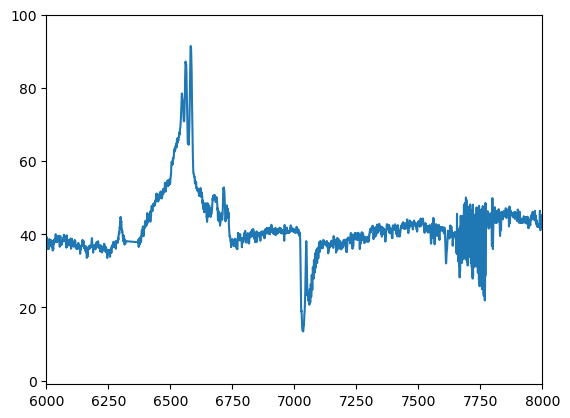

In [56]:
file_path = 'HET/combined_spectrum_20230113_0000022_exp01.fits'

t = Table.read(file_path)
t.sort('Wavelength')

z = 0.081
wl = t['Wavelength']/(1+z)
flux = t['F_lambda'] * (10**17)
err = t['e_F_lambda']

flux_lim = np.where(flux>0)[0]
wl=wl[flux_lim]
flux=flux[flux_lim]
err=err[flux_lim]

#wl_lim = np.where((wl>5900)&(wl<6950))
#wl=wl[wl_lim]
#flux=flux[wl_lim]
#err=err[wl_lim]

mask1 = np.where((wl<6320)|(wl>6370))
wl=wl[mask1]
flux=flux[mask1]
err=err[mask1]

plt.plot(wl, flux)
plt.xlim(6000, 8000)
plt.ylim(-1, 100)
plt.show()

# Correction

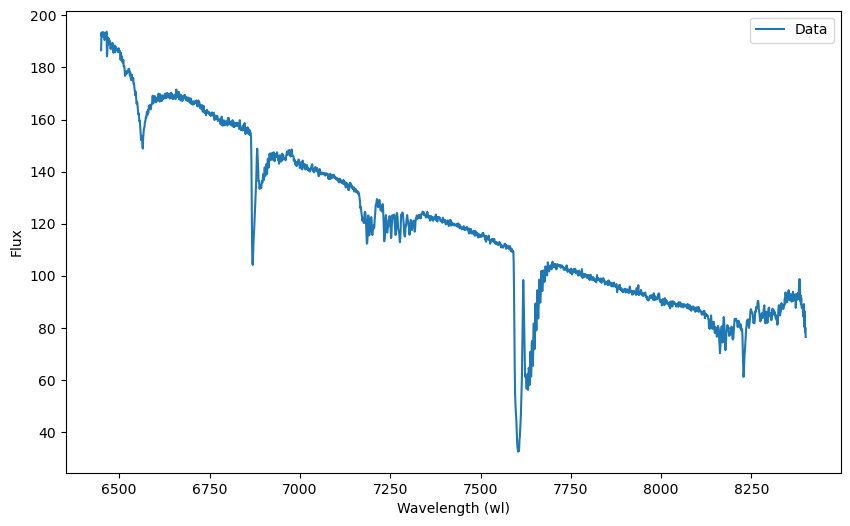

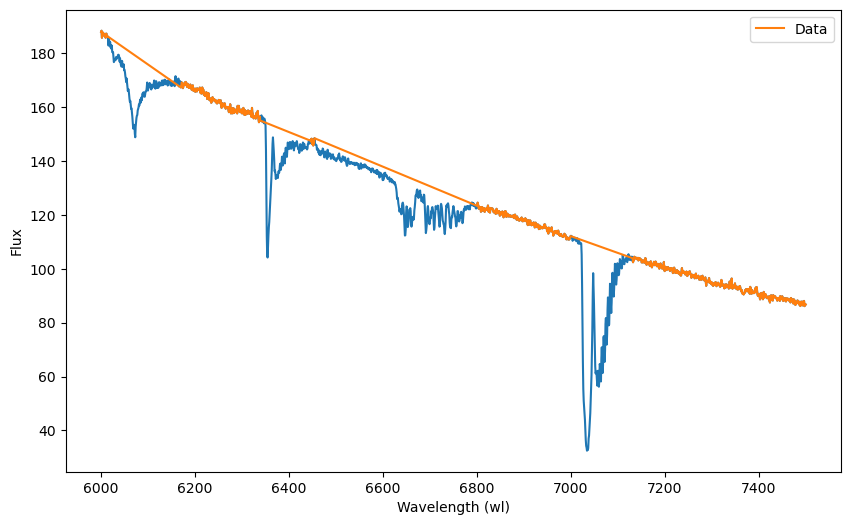

In [57]:
#file_name = 'bundle_20230529_standards/combined_spectrum_20230112_0000009_exp01.fits'
file_name = 'bundle_20230529_standards/spectrum_20230112_0000010_exp01_red.fits'
hdul = fits.open(file_name)
data = hdul[0].data
hdr = hdul[0].header

z = 0.081

wl = data[0]
wl = wl
flux = data[1] *(10**16)
err = data[2]

plt.figure(figsize=(10, 6))
plt.plot(wl, flux, label='Data')  # Original data


#plt.plot(wl_fit, flux_fit-flux_o, label='Best fit curve')  # Fitted curve
plt.xlabel('Wavelength (wl)')
plt.ylabel('Flux')
plt.legend()
plt.show()

wl = wl/(1+z)
mask0 = np.where((wl>6000) & (wl < 7500)) 
wl_o = wl[mask0]
flux_o = flux[mask0]
err_o = err[mask0]

mask1 = np.where((wl_o < 6015) | (wl_o > 6170)) 
wl = wl_o[mask1]
flux = flux_o[mask1]
err = err_o[mask1]

mask2 = np.where((wl < 6340) | (wl > 6445)) 
wl = wl[mask2]
flux = flux[mask2]
err = err[mask2]

mask3 = np.where((wl < 6455) | (wl > 6800)) 
wl = wl[mask3]
flux = flux[mask3]
err = err[mask3]


mask4 = np.where((wl < 7000) | (wl > 7130)) 
wl = wl[mask4]
flux = flux[mask4]
err = err[mask4]

plt.figure(figsize=(10, 6))
plt.plot(wl_o, flux_o)
plt.plot(wl, flux, label='Data')  # Original data

#plt.axvline(x=6445)
#plt.axvline(x=6455)

#plt.plot(wl_fit, flux_fit-flux_o, label='Best fit curve')  # Fitted curve
plt.xlabel('Wavelength (wl)')
plt.ylabel('Flux')
plt.legend()
plt.show()

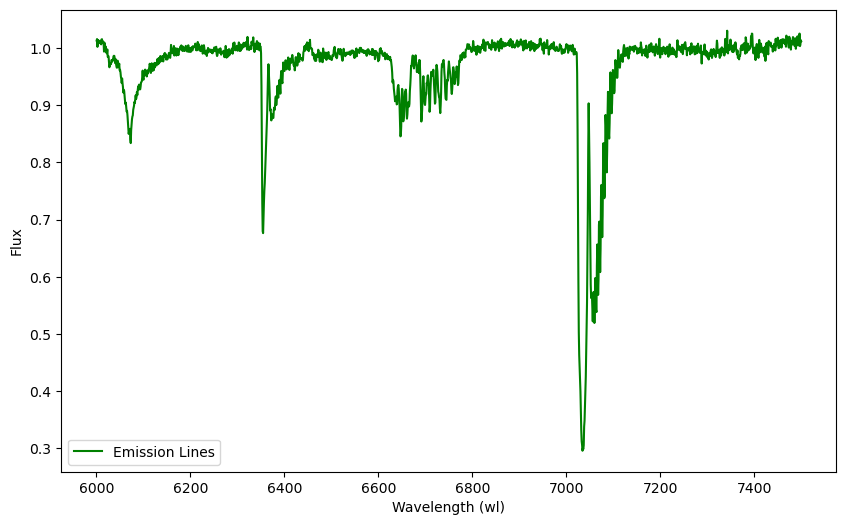

In [58]:
degree = 3
coefficients = np.polyfit(wl, flux, degree)
polynomial_continuum = np.poly1d(coefficients)(wl_o)
standard_flux = flux_o / polynomial_continuum
standard_wl = wl_o


plt.figure(figsize=(10, 6))
#plt.plot(wl_o, flux_o, label='Original Flux Data')
#plt.plot(wl_o, polynomial_continuum, label='Polynomial Continuum', color='orange')
plt.plot(standard_wl, standard_flux, label='Emission Lines', color='green')
plt.xlabel('Wavelength (wl)')
plt.ylabel('Flux')
#plt.ylim(0, 4)
plt.legend()
plt.show()

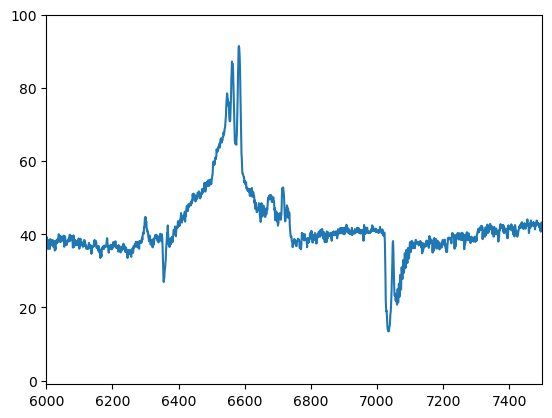

1715


In [59]:
file_path = 'HET/combined_spectrum_20230113_0000022_exp01.fits'

t = Table.read(file_path)
t.sort('Wavelength')

z = 0.081
wl = t['Wavelength']/(1+z)
flux = t['F_lambda'] * (10**17)
err = t['e_F_lambda'] * (10**17)

flux_lim = np.where(flux>0)[0]
source_wl=wl[flux_lim]
source_flux=flux[flux_lim]
source_err=err[flux_lim]

wl_lim = np.where((source_wl>6000)&(source_wl<7500))
source_wl=source_wl[wl_lim]
source_flux=source_flux[wl_lim]
source_err=source_err[wl_lim]


plt.plot(source_wl, source_flux)
plt.xlim(6000, 7500)
plt.ylim(-1, 100)
plt.show()

print(len(source_flux))

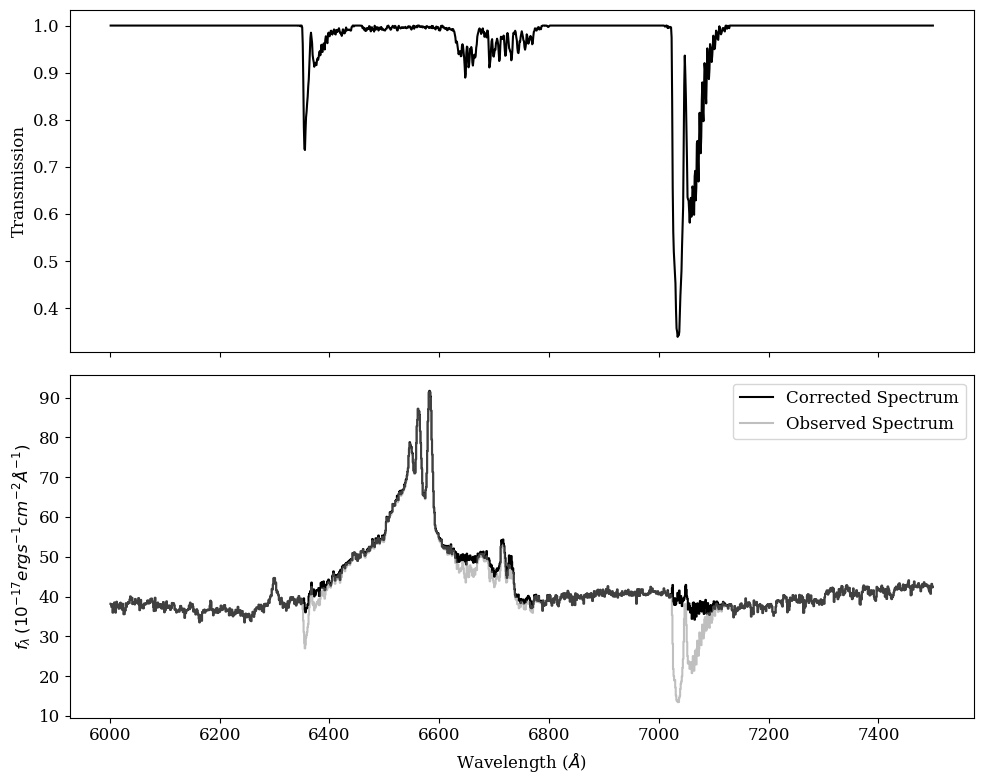

In [60]:
shift = 0
scale = 1.18

tmp = standard_flux

standard_wl = standard_wl + shift
tmp = (1-(1-tmp)**scale)
inf = np.where(np.isfinite(tmp) == False)[0]

standard_flux[inf] = 1
standard_flux = (1-(1-standard_flux)**scale)

mask1 = np.where(standard_wl < 6340)[0]
mask2 = np.where((standard_wl > 6445) & (standard_wl < 6455))[0]
mask3 = np.where((standard_wl > 6800) & (standard_wl < 7010))[0]
mask4 = np.where(standard_wl > 7130)[0]

standard_flux[mask1] = 1
standard_flux[mask2] = 1
standard_flux[mask3] = 1
standard_flux[mask4] = 1



bin_size = 1
bins = np.arange(start=min(np.min(source_wl), np.min(standard_wl)), stop=max(np.max(source_wl), np.max(standard_wl)) + bin_size, step=bin_size)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
wavelength = bin_centers


indices1 = np.digitize(source_wl, bins) - 1
indices2 = np.digitize(standard_wl, bins) - 1
source_flux = np.array([np.mean(source_flux[indices1 == i]) for i in range(len(bin_centers))])
standard_flux = np.array([np.mean(standard_flux[indices2 == i]) for i in range(len(bin_centers))])
binned_err = np.array([np.mean(source_err[indices1 == i]) for i in range(len(bin_centers))])



plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

# Standard Flux
axs[0].plot(wavelength, standard_flux, color='black')
#axs[1].axvline(x=6170, color='b', linestyle='--', linewidth=1)
#axs[1].axvline(x=6340, color='b', linestyle='--', linewidth=1)
#axs[1].axvline(x=6450, color='b', linestyle='--', linewidth=1)
#axs[1].axvline(x=6600, color='b', linestyle='--', linewidth=1)
#axs[1].axvline(x=6800, color='b', linestyle='--', linewidth=1)
#axs[1].axvline(x=7010, color='b', linestyle='--', linewidth=1)
#axs[1].axvline(x=7130, color='b', linestyle='--', linewidth=1)
#axs[1].set_title('Standard Flux vs. Wavelength')
#axs[0].set_xlabel('Wavelength ($\AA$)')
axs[0].set_ylabel('Transmission')


# Source Flux


axs[1].plot(wavelength, source_flux/standard_flux, color='black', label='Corrected Spectrum', drawstyle='steps-mid')
axs[1].plot(wavelength, source_flux, color='grey', label='Observed Spectrum', drawstyle='steps-mid', alpha=0.5)


#axs[0].axvline(x=6370, color='b', linestyle='--', linewidth=1, label="OI")
#axs[0].axvline(x=6303, color='b', linestyle='--', linewidth=1, label="OI")
#axs[0].set_title('Source Flux vs. Wavelength')
axs[1].set_xlabel('Wavelength ($\AA$)')
axs[1].set_ylabel("$f_{\lambda} \: (10^{-17} erg s^{-1} cm^{-2} \AA^{-1})$")
axs[1].legend()


# Corrected Source Flux
#axs[2].plot(wavelength, source_flux / standard_flux, color='green')
#axs[2].set_title('Corrected Source Flux vs. Wavelength')
#axs[2].set_xlabel('Wavelength (nm)')
#axs[2].set_ylabel('Flux')

plt.tight_layout()
plt.show()
#plt.saveplot("spectrum_correction.pdf")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


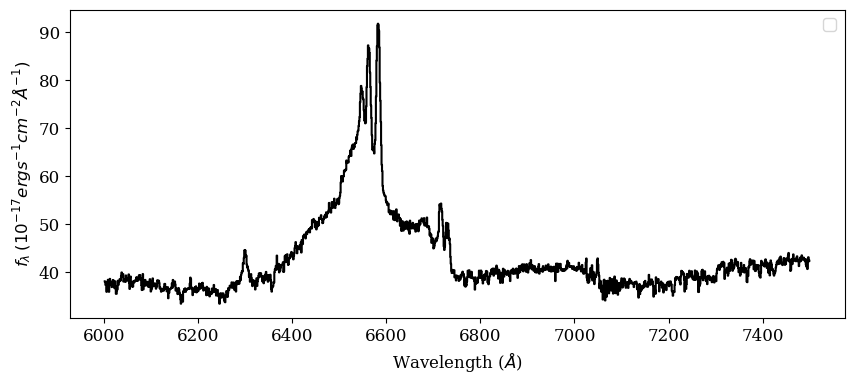

In [61]:
corrected_flux = source_flux / standard_flux
corrected_wl = bin_centers


plt.figure(figsize=(10, 4))
plt.plot(wavelength, corrected_flux, color="black", drawstyle='steps-mid')
#plt.axvline(x=6564.93, color='r', linestyle='--', linewidth=1, label="Halpha")
#plt.axvline(x=6085.90, color='orange', linestyle='--', linewidth=1, label="FVII")
#plt.axvline(x=6551.06, color='g', linestyle='--', linewidth=1, label="NII")
#plt.axvline(x=6585.64, color='g', linestyle='--', linewidth=1, label="NII")
#plt.axvline(x=6370, color='b', linestyle='--', linewidth=1, label="OI")
#plt.axvline(x=6303, color='b', linestyle='--', linewidth=1, label="OI")
#plt.axvline(x=6719, color='y', linestyle='--', linewidth=1, label="SII")
#plt.axvline(x=6734, color='y', linestyle='--', linewidth=1, label="SII")
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel("$f_{\lambda} \: (10^{-17} erg s^{-1} cm^{-2} \AA^{-1})$")
plt.legend()
plt.show()



## Functions

In [62]:
def kms_to_ang(dv,w0):
    """
    Convert a width in km/s to A.
    """
    c = 2.99792458e5 # km/s
    dlam = (dv/c)*w0
    return dlam

In [63]:
def powerlaw(x, scale, power):
    """
    Defines a power law

    Returns
    -------
    scale * x**power
    """
    return scale*(x/1000.)**-power

In [64]:
def gaussian(xarr,amplitude,cent,fwhm,normalized=False,return_components=False,return_hyperfine_components=False):
    """
    Returns a 1-dimensional gaussian of form
    A*np.exp(-(x-dx)**2/(2*w**2))

    Area is sqrt(2*pi*sigma^2)*amplitude - i.e., this is NOT a normalized
    gaussian, unless normalized=True in which case A = Area
    
    Parameters
    ----------
    xarr : np.ndarray
        array of x values
    amplitude : float
        Amplitude of the Gaussian, i.e. its peak value, unless
        normalized=True then A is the area of the gaussian
    cent : float
        Center or "shift" of the gaussian same units as xarr
    fwhm : float
        Full width at half maximum of the Gaussian in km/s
    return_components : bool
        dummy variable; return_components does nothing but is required by all
        fitters
    return_hyperfine_components : bool
        dummy variable; does nothing but is required by all
        fitters
    normalized : bool
        Return a normalized Gaussian?
    """ 
    fwhm = kms_to_ang(fwhm,cent)
    if fwhm == 0:
        return np.nan
    elif fwhm < 0:
        warnings.warn("Negative width in Gaussian: {0}.".format(fwhm),
                      PyspeckitWarning)

    width = fwhm/np.sqrt(8*np.log(2))
    xarr = np.array(xarr) # make sure xarr is no longer a spectroscopic axis
    model = amplitude*np.exp(-(xarr-cent)**2/(2.0*width**2))
    if normalized:
        return model / (np.sqrt(2*np.pi) * width**2)
    else:
        return model

In [65]:
def optical_agn_spectrum(wave_to_fit,pl_s,pl_e,\
                         sii1_f,sii1_cent,sii1_fwhm,\
                         sii2_f,sii2_cent,sii2_fwhm,\
                         oi1_f,oi1_cent,oi1_fwhm,\
                         oi2_f,oi2_cent,oi2_fwhm,\
                         fevii_f,fevii_cent,fevii_fwhm,\
                         nii1_f,nii1_cent,nii1_fwhm,\
                         nii2_f,nii2_cent,nii2_fwhm,\
                         halpha1_f,halpha1_cent,halpha1_fwhm,\
                         halpha2_f,halpha2_cent,halpha2_fwhm,\
                         halpha3_f,halpha3_cent,halpha3_fwhm,\
                         halpha4_f,halpha4_cent,halpha4_fwhm,\
                         return_components=False,return_hyperfine_components=False):
    """
    Calculates a full optical AGN spectral model.
    """
    
    #x = wave_to_fit.to_value()
    x = np.array(wave_to_fit)
    y = np.zeros_like(x)
    
    # powerlaw
    pl = powerlaw(x,pl_s,pl_e)      

    # broad [S II] - 6718.85 & 6733.72
    sii1 = gaussian(x,sii1_f,sii1_cent,sii1_fwhm,normalized=False)
    sii2 = gaussian(x,sii2_f,sii2_cent,sii2_fwhm,normalized=False)
    
    oi1 = gaussian(x,oi1_f,oi1_cent,oi1_fwhm,normalized=False)
    oi2 = gaussian(x,oi2_f,oi2_cent,oi2_fwhm,normalized=False)
    
    fevii = gaussian(x,fevii_f,fevii_cent,fevii_fwhm,normalized=False)
    
    nii1 = gaussian(x,nii1_f,nii1_cent,nii1_fwhm,normalized=False)
    nii2 = gaussian(x,nii2_f,nii2_cent,nii2_fwhm,normalized=False)
    
    # narrow and broad halpha line
    halpha1 = gaussian(x,halpha1_f,halpha1_cent,halpha1_fwhm,normalized=False)
    halpha2 = gaussian(x,halpha2_f,halpha2_cent,halpha2_fwhm,normalized=False)
    halpha3 = gaussian(x,halpha3_f,halpha3_cent,halpha3_fwhm,normalized=False)
    halpha4 = gaussian(x,halpha4_f,halpha4_cent,halpha4_fwhm,normalized=False)

    y = pl + sii1 + sii2 + halpha1 + halpha2 + halpha3 + halpha4 + nii1 + nii2 + oi1 + oi2 + fevii
    
    if return_components:
        y = {'model':y,\
             'pl':pl,\
            'sii1':sii1,\
             'sii2':sii2,\
             'oi1':oi1,\
             'oi2':oi2,\
             'fevii':fevii,\
             'nii1':nii1,\
            'nii2':nii2,\
            'halpha1':halpha1,\
            'halpha2':halpha2,\
            'halpha3':halpha3,\
            'halpha4':halpha4} 
    
    return y

In [66]:
def pl_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(plaw, 2,
            parnames=['scale','power'], 
            parlimited=[(False,False),(False,False)], 
            parlimits=[(0,0),(0,0)], 
            shortvarnames=('S','P')
            )
    myclass.__name__ = "pl"
    
    return myclass

In [67]:
def template_fitter(wave,templates,scale_factor,index,shift):
    '''
    given a series of templates (like stellar models by age or Fe II templates by convolution width),
    returns a spectrum interpolated between template spectra and scaled.
    Spectrum is also interpolated onto the wavelength vector of the observed data.
    
    params:
        wave - wavelength vector of observed data
        templates - 2D numpy array of shape (numpoints,num_templates+1), where 1st column is wavelength, subsequent columns are templates
        index - selected index within templates [0-num_templates]. Float, will interpolate between templates when index!=int
        scale_factor - multiplicative scale factor for spectrum
    '''
    num_templates=templates.shape[1]-1
    numpoints=templates.shape[0]
    
    if shift>=0:
        wave_temp=templates[:,0]*(1+shift)
    else:
        wave_temp=templates[:,0]/(1+shift)
    flux_temp=templates[:,1:]
    
    # Perform interpolation between templates
    if index==num_templates-1:
        spectrum=templates[:,-1]
    else:
        lower_idx=int(math.floor(index)+1) #+1 because 0th index is wavelength column
        lower_spectrum=templates[:,lower_idx] # this means lower in index, not necessarily in flux
        
        upper_idx=lower_idx+1
        upper_spectrum=templates[:,upper_idx]
        
        weight=(index+1)-lower_idx #1=choose upper spectrum value, 0=choose lower spectrum value, 0.5=choose midpoint
        
        distances=upper_spectrum-lower_spectrum # array of distances between selected spectra
        
        spectrum=lower_spectrum+(weight*distances)
        
    # Perform scaling
    scaled_spectrum=spectrum*scale_factor
    
    # interpolate spectrum onto wavelength vector of data
    final_spectrum=np.interp(wave,wave_temp,scaled_spectrum)

    return final_spectrum

In [68]:
def optical_agn_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(optical_agn_spectrum, 35,
            parnames=['pl_s','pl_e',\
                     'sii1_f','sii1_cent','sii1_fwhm',\
                      'sii2_f','sii2_cent','sii2_fwhm',\
                      'oi1_f','oi1_cent','oi1_fwhm',\
                      'oi2_f','oi2_cent','oi2_fwhm',\
                      'fevii_f','fevii_cent','fevii_fwhm',\
                      'nii1_f','nii1_cent','nii1_fwhm',\
                     'nii2_f','nii2_cent','nii2_fwhm',\
                     'halpha1_f','halpha1_cent','halpha1_fwhm',\
                     'haplha2_f','halpha2_cent','halpha2_fwhm',\
                     'haplha3_f','halpha3_cent','halpha3_fwhm',\
                     'haplha4_f','halpha4_cent','halpha4_fwhm'], 
            parlimited=[(False,False),(False,False),\
                       (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                       (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                       (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                       (False,False),(False,False),(False,False),\
                       (False,False),(False,False),(False,False),], 
            parlimits=[(0,0),(0,0),\
                      (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                      (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                      (0,0),(0,0),(0,0),\
                      (0,0),(0,0),(0,0),\
                      (0,0),(0,0),(0,0)]
            )
    myclass.__name__ = "optagn"
    
    return myclass

In [69]:
def plot_optical_agn_fit(wave,flux,model,wavemin,wavemax,ymin,ymax,xlabel,ylabel,plotfile,HARDCOPY=False,SHOW=True):
    
    sii1 = model['sii1']
    sii2 = model['sii2']
    oi1 = model['oi1']
    oi2 = model['oi2']
    fevii = model['fevii']
    halpha1 = model['halpha1']
    halpha2 = model['halpha2']
    halpha3 = model['halpha3']
    halpha4 = model['halpha4']
    nii1 = model['nii1'] 
    nii2 = model['nii2']
    
    
    fig = plt.figure(figsize=(18, 6))
    ax  = plt.axes()
    ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    ax.plot(wave,model['model'],color=pink,lw=2)
    ax.plot(wave,model['pl'],color=royal_blue)
    ax.plot(wave,sii1,color=salmon)
    ax.plot(wave,sii2,color=salmon)
    ax.plot(wave,oi1,color=salmon)
    ax.plot(wave,oi2,color=salmon)
    ax.plot(wave,fevii,color=salmon)
    ax.plot(wave,halpha1,color=blood_orange)
    ax.plot(wave,halpha2,color=green)
    ax.plot(wave,halpha3,color=green)
    ax.plot(wave,halpha4,color=green)
    ax.plot(wave,nii1,color=salmon)
    ax.plot(wave,nii2,color=dark_orange)
    ax.set_xlim(wavemin,wavemax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(xlabel,size=24)
    ax.set_ylabel(ylabel,size=24)
    plt.tight_layout()
    if HARDCOPY: fig.savefig(plotfile+'_fullfit.pdf', format='pdf')
    if SHOW: plt.show()
    plt.close(fig)
    
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    #ax.set_xlim(4700,5100)
    #ax.set_ylim(ymin,ymax)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_Hbfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)
    #
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    #ax.set_xlim(3715,4450)
    #ax.set_ylim(ymin,ymax)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_SBfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)

## Setup for plotting

In [70]:
# SETUP 
##############################################################
##############################################################
fontfamily = 'Times New Roman'
matplotlib.rcParams['font.family'] = fontfamily
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
plt.rc('xtick.major',pad=2)
plt.rc('ytick.major',pad=2)
plt.rc('xtick.minor',pad=2)
plt.rc('ytick.minor',pad=2)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('font',size=24,weight='bold')
plt.rcParams['axes.labelweight'] = 'bold'

blood_orange = [204/255,17/255,0/255]
indian_red = [176/255,23/255,31/255]
indian_red = [200/255,23/255,31/255]
green = [0/255,205/255,0/255]
dark_orange = [255/255,127/255,0/255]
goldenrod = [255/255,193/255,37/255]
midnight_blue = [25/255,25/255,112/255]
transparent_blue = [138/255,181/255,220/255]
gray = [130/255,130/255,130/255]
dark_gray = [50/255,50/255,50/255]
salmon = [250/255,128/255,114/255]
royal_blue = [0/255,0/255,200/255]
turquoise  = [0/255,204/255,204/255]
cyan  = [0/255,255/255,255/255]
pink = [255/255,0/255,127/255]
med_pink = [191/255, 0/255, 96/255]
dark_pink = [128/255, 0/255, 64/255]

## Fit parameters from a rough spectral decomposition

Do a very rough spectral decomposition to the H$\beta$ region in order to get some guesses for starting parameters in this regime.

This creates a "continuum subtracted" spectrum by subtracting a hardcoded value, then fits Gaussians and saves their best-fit values to use as a starting guess later. It won't work on any other spectrum because of the continuum subtraction.

In [71]:
flux = corrected_flux
lam = corrected_wl
err = binned_err


In [72]:
sii1 = 6718.85
sii2 = 6733.72
halpha = 6564.93
nii1 = 6551.06
nii2 = 6585.64
oi2 = 6370.46
oi1 = 6303.05
fevii = 6085.90

sii2_off = sii2/sii1
nii1_off = nii1/sii1
nii2_off = nii2/sii1
oi1_off = oi1/sii1
oi2_off = oi2/sii1
halpha_off = halpha/sii1
fevii_off = fevii/sii1 


c = 2.99e5 # km/s

In [73]:
guesses = [5,0,\
          10, sii1, 800,\
           10, sii2, 800,\
           10, oi1, 800,\
           10, oi2, 800,\
           10, fevii, 800,\
          10, nii1, 800,\
           10, nii2, 800,\
          10, halpha, 800,\
          5, halpha, 3000,\
          5, halpha, 1500,\
          5, 6700, 1500]
           
tied = ['','',\
       '', '', '',\
        '', 'p[3] * {0}'.format(sii2_off), 'p[4]',\
        '', 'p[3] * {0}'.format(oi1_off), 'p[4]',\
        'p[8]/3', 'p[3] * {0}'.format(oi2_off), 'p[4]',\
        '', 'p[3] * {0}'.format(fevii_off), '',\
       '', 'p[3] * {0}'.format(nii1_off), 'p[4]',\
        '', 'p[3] * {0}'.format(nii2_off), 'p[4]',\
       '', 'p[3] * {0}'.format(halpha_off), 'p[4]',\
       '', '', '',\
       'p[26]/3', '', '',\
       '', '', '']

step = [0.5, 0.05,\
       0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
       0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
       0.5, 0.1, 5,\
        0.5, 0.1, 5,\
       0.5, 0.1, 5]

fixed = [0,0,\
        0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
        0,0,0,\
         0,0,0,\
        0,0,0,\
         0,0,0,\
         0,0,0,\
        0,0,0]

In [74]:
print(len(guesses))

35


In [75]:
# this actually does the fit after resetting the spectrum
spec = pyspeckit.Spectrum(data=flux,xarr=lam,error=err)
spec.unit = 'erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$'
spec.xarr.set_unit = u.angstrom #'$\\AA$'
spec.xarr.xtype='angstrom'
spec.Registry.add_fitter('opticalagn',optical_agn_fitter(),35)
spec.specfit.selectregion(xmin=6000,xmax=7000)
spec.specfit(fittype='opticalagn',vheight=False,guesses=guesses,tied=tied,fixed=fixed,parsteps=step,maxiter=500,baseline=False,subtract_baseline=False,quiet=False)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1000 [pyspeckit.spectrum.interactive]
Iter       1    CHI-SQUARE =  3559346.159  DOF =  980
   PL_S0 = 5  
   PL_E0 = 0  
   SII1_F0 = 10  
   SII1_CENT0 = 6718.85  
   SII1_FWHM0 = 800  
   SII2_F0 = 10  
   SII2_CENT0 = 6733.72  
   SII2_FWHM0 = 800  
   OI1_F0 = 10  
   OI1_CENT0 = 6303.05  
   OI1_FWHM0 = 800  
   OI2_F0 = 3.333333333  
   OI2_CENT0 = 6370.46  
   OI2_FWHM0 = 800  
   FEVII_F0 = 10  
   FEVII_CENT0 = 6085.9  
   FEVII_FWHM0 = 800  
   NII1_F0 = 10  
   NII1_CENT0 = 6551.06  
   NII1_FWHM0 = 800  
   NII2_F0 = 10  
   NII2_CENT0 = 6585.64  
   NII2_FWHM0 = 800  
   HALPHA1_F0 = 10  
   HALPHA1_CENT0 = 6564.93  
   HALPHA1_FWHM0 = 800  
   HAPLHA2_F0 = 5  
   HALPHA2_CENT0 = 6564.93  
   HALPHA2_FWHM0 = 3000  
   HAPLHA3_F0 = 1.666666667  
   HALPHA3_CENT0 = 6564.93  
   HALPHA3_FWHM0 = 1500  
   HAPLHA4_F0 = 5  
   HALPHA4_CENT0 = 6700  
   HALPHA4_FWHM0 = 1500  
Iter       2    CHI-SQUARE =  1451185.999  D

Iter      10    CHI-SQUARE =  5307.908826  DOF =  980
   PL_S0 = 13.75877777  
   PL_E0 = -0.5528352246  
   SII1_F0 = 11.2001126  
   SII1_CENT0 = 6715.983703  
   SII1_FWHM0 = 420.5784733  
   SII2_F0 = 8.844932455  
   SII2_CENT0 = 6730.84736  
   SII2_FWHM0 = 420.5784733  
   OI1_F0 = 6.279441969  
   OI1_CENT0 = 6300.361086  
   OI1_FWHM0 = 420.5784733  
   OI2_F0 = 2.093147323  
   OI2_CENT0 = 6367.742328  
   OI2_FWHM0 = 420.5784733  
   FEVII_F0 = 0.8018459279  
   FEVII_CENT0 = 6083.303723  
   FEVII_FWHM0 = 2128.234158  
   NII1_F0 = 14.13609834  
   NII1_CENT0 = 6548.265284  
   NII1_FWHM0 = 420.5784733  
   NII2_F0 = 32.07701621  
   NII2_CENT0 = 6582.830532  
   NII2_FWHM0 = 420.5784733  
   HALPHA1_F0 = 23.63506706  
   HALPHA1_CENT0 = 6562.129367  
   HALPHA1_FWHM0 = 420.5784733  
   HAPLHA2_F0 = 21.39423711  
   HALPHA2_CENT0 = 6553.912844  
   HALPHA2_FWHM0 = 5840.965267  
   HAPLHA3_F0 = 7.131412371  
   HALPHA3_CENT0 = 6470.891437  
   HALPHA3_FWHM0 = 6081.976334  
 

Iter      19    CHI-SQUARE =  2695.794334  DOF =  980
   PL_S0 = 9.04101979  
   PL_E0 = -0.7712938733  
   SII1_F0 = 11.14661256  
   SII1_CENT0 = 6716.050875  
   SII1_FWHM0 = 392.0368025  
   SII2_F0 = 8.311804714  
   SII2_CENT0 = 6730.91468  
   SII2_FWHM0 = 392.0368025  
   OI1_F0 = 7.579445207  
   OI1_CENT0 = 6300.4241  
   OI1_FWHM0 = 392.0368025  
   OI2_F0 = 2.526481736  
   OI2_CENT0 = 6367.806017  
   OI2_FWHM0 = 392.0368025  
   FEVII_F0 = 1.735226075  
   FEVII_CENT0 = 6083.364567  
   FEVII_FWHM0 = 4591.105678  
   NII1_F0 = 10.52551864  
   NII1_CENT0 = 6548.330777  
   NII1_FWHM0 = 392.0368025  
   NII2_F0 = 31.60640208  
   NII2_CENT0 = 6582.896371  
   NII2_FWHM0 = 392.0368025  
   HALPHA1_F0 = 20.5726616  
   HALPHA1_CENT0 = 6562.194999  
   HALPHA1_FWHM0 = 392.0368025  
   HAPLHA2_F0 = 29.33528552  
   HALPHA2_CENT0 = 6549.592972  
   HALPHA2_FWHM0 = 4795.15679  
   HAPLHA3_F0 = 9.778428506  
   HALPHA3_CENT0 = 6440.625068  
   HALPHA3_FWHM0 = 4363.614361  
   HAP

Iter      28    CHI-SQUARE =  2620.727561  DOF =  980
   PL_S0 = 6.730422678  
   PL_E0 = -0.9259809045  
   SII1_F0 = 11.17185336  
   SII1_CENT0 = 6716.043183  
   SII1_FWHM0 = 393.5931547  
   SII2_F0 = 8.335225461  
   SII2_CENT0 = 6730.906971  
   SII2_FWHM0 = 393.5931547  
   OI1_F0 = 7.998221482  
   OI1_CENT0 = 6300.416885  
   OI1_FWHM0 = 393.5931547  
   OI2_F0 = 2.666073827  
   OI2_CENT0 = 6367.798724  
   OI2_FWHM0 = 393.5931547  
   FEVII_F0 = 2.277166271  
   FEVII_CENT0 = 6083.3576  
   FEVII_FWHM0 = 5661.604595  
   NII1_F0 = 10.63663005  
   NII1_CENT0 = 6548.323278  
   NII1_FWHM0 = 393.5931547  
   NII2_F0 = 31.52343433  
   NII2_CENT0 = 6582.888832  
   NII2_FWHM0 = 393.5931547  
   HALPHA1_F0 = 20.63015324  
   HALPHA1_CENT0 = 6562.187484  
   HALPHA1_FWHM0 = 393.5931547  
   HAPLHA2_F0 = 29.32105776  
   HALPHA2_CENT0 = 6549.7114  
   HALPHA2_FWHM0 = 4841.419425  
   HAPLHA3_F0 = 9.77368592  
   HALPHA3_CENT0 = 6439.698755  
   HALPHA3_FWHM0 = 4526.368301  
   HA

Iter      36    CHI-SQUARE =  2620.710013  DOF =  980
   PL_S0 = 6.726822733  
   PL_E0 = -0.9262954781  
   SII1_F0 = 11.17210718  
   SII1_CENT0 = 6716.043139  
   SII1_FWHM0 = 393.5954609  
   SII2_F0 = 8.335673555  
   SII2_CENT0 = 6730.906927  
   SII2_FWHM0 = 393.5954609  
   OI1_F0 = 7.998443125  
   OI1_CENT0 = 6300.416844  
   OI1_FWHM0 = 393.5954609  
   OI2_F0 = 2.666147708  
   OI2_CENT0 = 6367.798683  
   OI2_FWHM0 = 393.5954609  
   FEVII_F0 = 2.277550814  
   FEVII_CENT0 = 6083.35756  
   FEVII_FWHM0 = 5667.292075  
   NII1_F0 = 10.6374138  
   NII1_CENT0 = 6548.323235  
   NII1_FWHM0 = 393.5954609  
   NII2_F0 = 31.52318706  
   NII2_CENT0 = 6582.888789  
   NII2_FWHM0 = 393.5954609  
   HALPHA1_F0 = 20.63047898  
   HALPHA1_CENT0 = 6562.187441  
   HALPHA1_FWHM0 = 393.5954609  
   HAPLHA2_F0 = 29.32033983  
   HALPHA2_CENT0 = 6549.714126  
   HALPHA2_FWHM0 = 4841.460756  
   HAPLHA3_F0 = 9.773446611  
   HALPHA3_CENT0 = 6439.699648  
   HALPHA3_FWHM0 = 4527.80922  
   

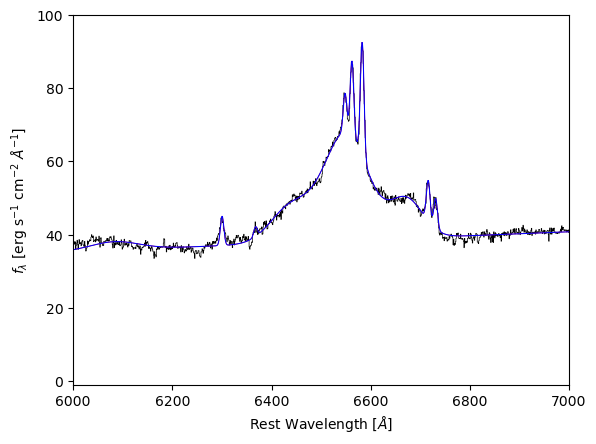

In [76]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
spec.plotter(xmin=6000,xmax=7000,ymin=-1,ymax=100,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)
spec.specfit.plot_components()
plt.show()

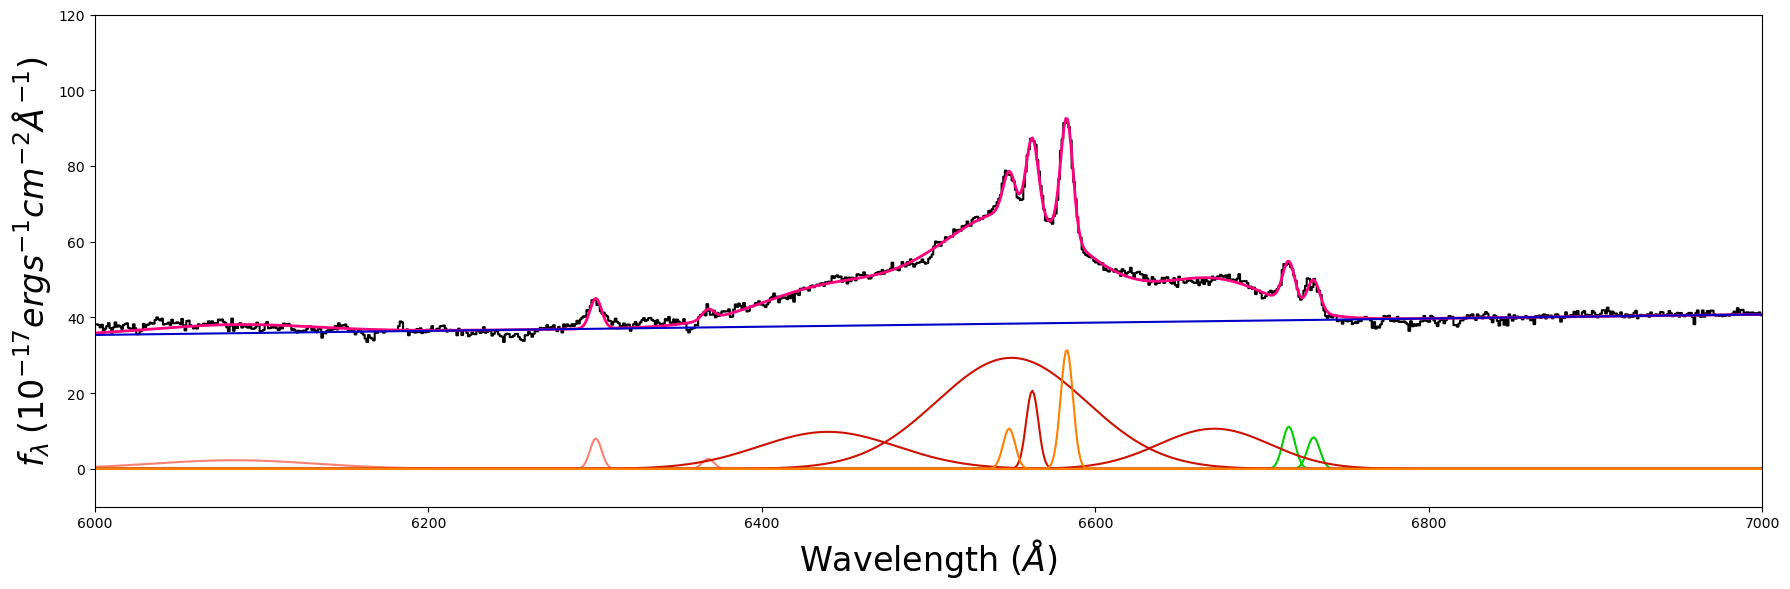

In [83]:
best_model = optical_agn_spectrum(lam,*spec.specfit.parinfo.values,return_components=True)
wavemin = 1000.
wavemax = 1650.
ymin = -100.
ymax = 400.
wave = lam
flux = flux
model = best_model
xlabel = 'Wavelength $[\AA]$'
ylabel = '$f_\lambda [10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]'
plotfile = '../plots/j0950/plots/spec-52509-0902-0498'
HARDCOPY = False
SHOW = True

plot_optical_agn_fit(lam,flux,best_model,6000,7000,-10,120,'Wavelength $(\AA)$',\
                     "$f_{\lambda} \: (10^{-17} erg s^{-1} cm^{-2} \AA^{-1})$",\
                     plotfile,HARDCOPY=False,SHOW=True)